In [1]:
import Ramsey_ExperimentV3
import estimator
import numpy as np

In [23]:
from tqdm import tqdm
import random

T = np.pi
uni_delay = np.linspace(0, T, 20)
# shots = np.arange(500, 20000, 2000)
shots= np.logspace(2,6,num=6-2+1,base=10,dtype='int')
errors_fisher = []
errors_local = []
uniform_local = []
n = 1
delay = [1]
fisher_delay = [0.4439410861020235, 1.784695781691183]


repetitions = 100


for rep in range(repetitions):
    rep_error_fisher = []
    rep_error_local = []
    rep_error_uniform = []

    W = [random.gauss(1, 0) for _ in range(n)]
    Decay = [random.gauss(0.7, 0) for _ in range(n)]
    J = {}
    J_list = [random.gauss(1, 0) for _ in range(n - 1)]
    for i in range(n - 1):  # Only connect to the next neighbor
        J[(i, i + 1)] = J_list[i]

    for s in tqdm(shots, desc=f"Repetition {rep}"):
        # batch_x, batch_y = Ramsey_ExperimentV2.ramsey_global(n, s, delay, Decay, W, J)
        batch_x_det, batch_y_det, batch_x_cross, batch_y_cross = Ramsey_ExperimentV3.ramsey_local(n, s, delay, Decay,
                                                                                                  W, J)
        batch_x_det_uni, batch_cross_uni = Ramsey_ExperimentV3.ramsey_local_X(n, s, uni_delay, Decay, W, J)

        batch_det, batch_cross = Ramsey_ExperimentV3.ramsey_local_X(n, s, fisher_delay, Decay, W, J)

        Decay_local, W_local, J_local = estimator.one_by_one_fit(batch_x_det, batch_y_det, batch_x_cross,
                                                                 batch_y_cross)
        Decay_fisher, W_fisher, J_fisher = estimator.one_by_one_X(batch_det, batch_cross)

        Decay_uni, W_uni, J_uni = estimator.one_by_one_X(batch_x_det_uni, batch_cross_uni)
        # Decay_uni, W_uni, J_uni = estimator.one_by_one_fit(batch_x_det_uni, batch_y_det_uni, batch_x_cross_uni, batch_y_cross_uni)

        rep_error_fisher.append(estimator.percent_error(np.concatenate([Decay, W, J_list]),
                                                        np.concatenate([Decay_fisher, W_fisher, J_fisher])))
        rep_error_local.append(estimator.percent_error(np.concatenate([Decay, W, J_list]),
                                                       np.concatenate([Decay_local, W_local, J_local])))
        rep_error_uniform.append(estimator.percent_error(np.concatenate([Decay, W, J_list]),
                                                         np.concatenate([Decay_uni,W_uni, J_uni])))

    errors_fisher.append(rep_error_fisher)
    errors_local.append(rep_error_local)
    uniform_local.append(rep_error_uniform)

Repetition 0:   0%|          | 0/5 [00:00<?, ?it/s]C:\Projects\Crosstalk\estimator.py:36: OptimizeWarning: Covariance of the parameters could not be estimated
  params, params_covariance, *c = curve_fit(model_func, t_points, z_points, p0=initial_guess, bounds=bounds)
C:\Projects\Crosstalk\estimator.py:66: OptimizeWarning: Covariance of the parameters could not be estimated
  params, params_covariance, *c = curve_fit(model_func, t_points, z_points, p0=initial_guess, bounds=bounds)
Repetition 99: 100%|██████████| 5/5 [00:03<00:00,  1.44it/s]


In [27]:
errors_fisher_reshaped = list(map(list, zip(*errors_fisher)))
errors_local_reshaped = list(map(list, zip(*errors_local)))
errors_uniform_reshaped = list(map(list, zip(*uniform_local)))

errors_fisher_median, errors_fisher_std = estimator.mean_of_medians(errors_fisher_reshaped, 10)
errors_local_median,errors_local_std  = estimator.mean_of_medians(errors_local_reshaped, 10)
errors_uniform_median, errors_uniform_std = estimator.mean_of_medians(errors_uniform_reshaped, 10)

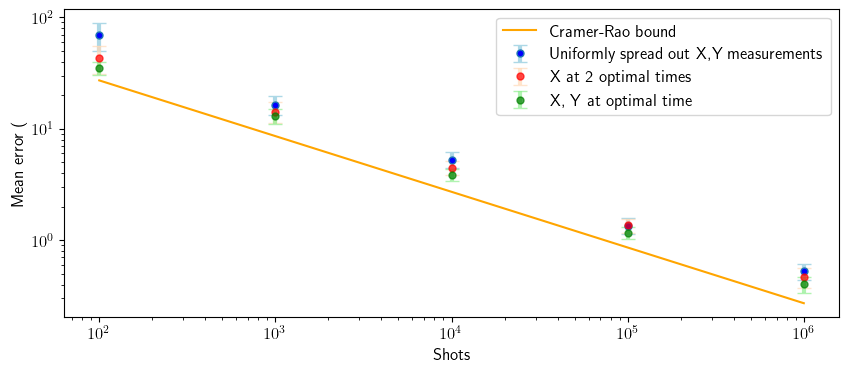

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.rcParams['text.usetex'] = True
font = {'family': 'normal',
        'weight': 'bold',
        'size': 14}# Adjust the figure size to make the plot longer


# plt.rc('font', **font)
# plt.scatter(shots, 100 * np.array(errors_uniform_median), color='blue', s=20,
#          label='X at 20 fixed times')
# plt.scatter(shots, 100 * np.array(errors_fisher_median), color='red', s=20,
#          label='X at 2 non-optimal times')
# plt.scatter(shots, 100 * np.array(errors_local_median), color='green', s=20,
#          label='X, Y at non-optimal time')



plt.errorbar(shots, 100*np.array(errors_uniform_median), yerr=100*np.array(errors_uniform_std), fmt='o', capsize=5, ecolor='lightblue', elinewidth=3, markerfacecolor='blue', markersize=5, label='Uniformly spread out X,Y measurements')

plt.errorbar(shots, 100*np.array(errors_fisher_median), yerr=100*np.array(errors_fisher_std), fmt='o', capsize=5, ecolor='peachpuff', elinewidth=3, color='red', markersize=5, label='X at 2 optimal times', alpha=0.7)

plt.errorbar(shots, 100*np.array(errors_local_median), yerr=100*np.array(errors_local_std), fmt='o', capsize=5, ecolor='lightgreen', elinewidth=3, color='green', markersize=5, label='X, Y at optimal time', alpha=0.7)

# Shots_2q = [100, 1000, 10000, 100000, 1000000]
# Errors_2q = [50.530481, 18.415648, 7.961954, 6.401243, 6.696693]
# plt.plot(Shots_2q, Errors_2q, linestyle='', marker='o', color='blue', markersize=5, label='2 qubits')
# shots3q=[10000]
# errors3q=[5.809173305]
# plt.plot(shots3q, errors3q, linestyle='', marker='o', color='red', markersize=5, label='More data')
# plt.title(f'Error vs shots W={W} Decay={Decay} ')
# plt.title(f'{n} qubits')
plt.plot(shots, 100*np.e/ np.sqrt(shots), '-', label='Cramer-Rao bound', color = 'orange')
plt.xlabel('Shots')
plt.ylabel('Mean error (%)')
plt.yscale('log')
plt.xscale('log')
# plt.grid()

plt.rcParams['lines.markersize'] = 10
# Example size for markers
plt.rcParams['font.size'] = 12         # Example size for font
plt.legend()

In [29]:
import pandas as pd

results_df = pd.DataFrame({
    "shots": shots,
    "errors_fisher_median": errors_fisher_median,
    "errors_fisher_std": errors_fisher_std,
    "errors_local_median": errors_local_median,
    "errors_local_std": errors_local_std,
    "errors_uniform_median": errors_uniform_median,
    "errors_uniform_std": errors_uniform_std
})

# Saving to Excel
results_df.to_excel('C:\Projects\Crosstalk\data_for_paper/errors_optimal.xlsx', index=False)